In [193]:
#import dependancies
import pandas as pd
from sqlalchemy import create_engine
import gmaps
import keyring
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pymongo
import json

In [162]:
#defines path for csv/tsv's
# path_1 = "Resources/county_market_tracker.tsv000"
path_2 = "Resources/state_market_tracker.tsv000"
# path_3 = "Resources/us_national_market_tracker.tsv000"
path_4 = "Resources/data_cleaned_2021.csv"

In [242]:
#reads in data to pandas dataframes
# county_df = pd.read_csv(path_1,sep='\t')
state_df = pd.read_csv(path_2,sep='\t')
# national_df = pd.read_csv(path_3,sep='\t')
salary_df = pd.read_csv(path_4)

In [299]:
#prints out heads of dataframes being used
state_df.head()
#mean_state_head()

,State Code,Median Sale Price,Median Paid Per Sqft,Number of Listings
0,OK,162200,77.0,81.0
1,VT,317900,177.0,2760.0
4,MO,152000,135.0,487.0
5,NM,385500,218.0,1034.0
9,OH,156100,111.0,2535.0


In [298]:
# mean_salary_df.head()
salary_df.head()

,Rating,Lower Salary,Upper Salary,Avg Salary(K),Job Location,Job Title
0,3.8,53,91,72.0,NM,data scientist
1,3.4,63,112,87.5,MD,data scientist
2,4.8,80,90,85.0,FL,data scientist
3,3.8,56,97,76.5,WA,data scientist
4,2.9,86,143,114.5,NY,data scientist


In [192]:
#prints out list of columns for salary_df
for col in salary_df.columns:
    print(col)

Rating
Lower Salary
Upper Salary
Avg Salary(K)
Job Location
Job Title
Seniority by Title


In [244]:
#Grabs columns we need from salary_df
salary_df = salary_df[['Rating','Lower Salary','Upper Salary','Avg Salary(K)','Job Location','job_title_sim','seniority_by_title']]

In [245]:
#Renames columns in salary_df
salary_df = salary_df.rename(columns={'job_title_sim':'Job Title','seniority_by_title':'Seniority by Title'})

In [246]:
#drops columns not needed in state_df
state_df = state_df.drop(columns={
                         'period_begin',
                         'period_duration',
                         'region_type',
                         'region_type_id',
                         'table_id',
                         'is_seasonally_adjusted',
                         'region',
                         'city',
                         'property_type',
                         'property_type_id',
                         'median_sale_price_mom',
                         'median_sale_price_yoy',
                         'median_list_price',
                         'median_list_price_mom',
                         'median_list_price_yoy',
                         'median_ppsf_mom',
                         'median_ppsf_yoy',
                         'median_list_ppsf',
                         'median_list_ppsf_mom',
                         'median_list_ppsf_yoy',
                         'homes_sold',
                         'homes_sold_mom',
                         'homes_sold_yoy',
                         'pending_sales',
                         'pending_sales_mom',
                         'pending_sales_yoy',
                         'new_listings',
                         'new_listings_mom',
                         'new_listings_yoy',
                         # inventory?
                         'inventory_mom',
                         'inventory_yoy',
                         'months_of_supply',
                         'months_of_supply_mom',
                         'months_of_supply_yoy',
                         'median_dom',
                         'median_dom_mom',
                         'median_dom_yoy',
                         'avg_sale_to_list',
                         'avg_sale_to_list_mom',
                         'avg_sale_to_list_yoy',
                         'sold_above_list',
                         'sold_above_list_mom',
                         'sold_above_list_yoy',
                         'price_drops',
                         'price_drops_mom',
                         'price_drops_yoy',
                         'off_market_in_two_weeks',
                         'off_market_in_two_weeks_mom',
                         'off_market_in_two_weeks_yoy',
                         'parent_metro_region',
                         'parent_metro_region_metro_code',
                         'last_updated'})

In [247]:
#Rename columns of state_df
state_df = state_df.rename(columns={'period_end':'End Date','state':'State','median_sale_price':'Median Sale Price','median_ppsf':'Median Paid Per Sqft','inventory':'Number of Listings','state_code':'State Code'})

In [248]:
#Counts values for each positon
salary_df['Job Title'].value_counts()

data scientist                    313
other scientist                   143
data engineer                     119
analyst                           101
machine learning engineer          22
Data scientist project manager     16
na                                 10
data analitics                      8
data modeler                        5
director                            5
Name: Job Title, dtype: int64

In [249]:
#get types and change them to something more convenient
state_df['End Date'] = pd.to_datetime(state_df['End Date'], format='%Y-%m-%d')
state_df['State Code'] = state_df['State Code'].astype('string')
state_df.dtypes

End Date                datetime64[ns]
State                           object
State Code                      string
Median Sale Price                int64
Median Paid Per Sqft           float64
Number of Listings             float64
dtype: object

In [250]:
#Drops rows 2018 and older
state_df = state_df[state_df['End Date'].dt.year > 2018]

In [251]:
#Converting types to strings
salary_df['Job Location'] = salary_df['Job Location'].astype('string')
salary_df['Job Title'] = salary_df['Job Title'].astype('string')
salary_df['Seniority by Title'] = salary_df['Seniority by Title'].astype('string')
salary_df.dtypes

Rating                float64
Lower Salary            int64
Upper Salary            int64
Avg Salary(K)         float64
Job Location           string
Job Title              string
Seniority by Title     string
dtype: object

In [260]:
#Drop more columns not needed
state_df = state_df.drop(columns={'State','End Date'})

In [252]:
#Drop senior and junior titles
salary_df = salary_df.drop(columns={'Seniority by Title'})
# salary_df = salary_df[salary_df['Seniority by Title'] != "sr"]
# salary_df = salary_df[salary_df['Seniority by Title'] != "jr"]

In [253]:
# state_df['State'].value_counts()
print(state_df['State'].nunique())
print(salary_df['Job Location'].nunique())

47
37


In [310]:
#group state_df into mean of state
mean_state_df = state_df.groupby(state_df['State Code']).mean()
mean_state_df[['Median Sale Price','Median Paid Per Sqft','Number of Listings']] = mean_state_df[['Median Sale Price','Median Paid Per Sqft','Number of Listings']].round()
#Renames Median columns to Mean Columns (TECHNICALLY: column values are mean of state median salaries)
mean_state_df = mean_state_df.rename(columns={'Number of Listings':'Mean Number of Listings','Median Sale Price':'Mean Sale Price','Median Paid Per Sqft':'Mean Paid Per Sqft'})
mean_state_df = mean_state_df.reset_index()
mean_state_df.head()

,State Code,Mean Sale Price,Mean Paid Per Sqft,Mean Number of Listings
0,AK,303015.0,167.0,1090.0
1,AL,189149.0,109.0,3168.0
2,AR,184566.0,107.0,3066.0
3,AZ,294833.0,198.0,7697.0
4,CA,670961.0,420.0,24935.0


In [319]:
#groups salary by state calculates state mean, also rounds columns.
mean_salary_df = salary_df.groupby(salary_df['Job Location']).mean()
mean_salary_df[['Lower Salary','Upper Salary','Avg Salary(K)']] = mean_salary_df[['Lower Salary','Upper Salary','Avg Salary(K)']].round()
mean_salary_df[['Lower Salary','Upper Salary','Avg Salary(K)']] = (mean_salary_df[['Lower Salary','Upper Salary','Avg Salary(K)']]*1000)
mean_salary_df['Rating'] = mean_salary_df['Rating'].round(2)

In [320]:
#reset index and rename column to match mean_state_df for merge
mean_salary_df = mean_salary_df.reset_index()
mean_salary_df = mean_salary_df.rename(columns={'Job Location':'State Code'})

In [321]:
#Merge both mean dataframes 
merged_df = pd.merge(mean_salary_df,mean_state_df,how='inner',on='State Code')
merged_df.head()

,State Code,Rating,Lower Salary,Upper Salary,Avg Salary(K),Mean Sale Price,Mean Paid Per Sqft,Mean Number of Listings
0,AL,4.21,41000.0,75000.0,58000.0,189149.0,109.0,3168.0
1,AZ,3.58,66000.0,106000.0,86000.0,294833.0,198.0,7697.0
2,CA,3.60,92000.0,155000.0,124000.0,670961.0,420.0,24935.0
3,CO,3.79,64000.0,108000.0,86000.0,458560.0,207.0,4735.0
4,CT,3.40,58000.0,85000.0,71000.0,359550.0,185.0,6423.0


In [322]:
#Create 'Home Budget Estimate' column in merged_df by using formula '30% of yearly salary average - Yearly Estimated mortgage'
merged_df['Home Budget Surplus'] = (((merged_df['Avg Salary(K)'])*0.30)-((merged_df['Mean Sale Price'])/30))
merged_df['Home Budget Surplus'] = merged_df['Home Budget Surplus'].round()
merged_df.head()

,State Code,Rating,Lower Salary,Upper Salary,Avg Salary(K),Mean Sale Price,Mean Paid Per Sqft,Mean Number of Listings,Home Budget Surplus
0,AL,4.21,41000.0,75000.0,58000.0,189149.0,109.0,3168.0,11095.0
1,AZ,3.58,66000.0,106000.0,86000.0,294833.0,198.0,7697.0,15972.0
2,CA,3.60,92000.0,155000.0,124000.0,670961.0,420.0,24935.0,14835.0
3,CO,3.79,64000.0,108000.0,86000.0,458560.0,207.0,4735.0,10515.0
4,CT,3.40,58000.0,85000.0,71000.0,359550.0,185.0,6423.0,9315.0


In [301]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [302]:
#Creates/Defines database in Mongo
db = client.ds_housing_db

In [303]:
#Define tables in database
state = db.state
salary = db.salary
merged = db.merged

In [304]:
#Creates and inserts merged_df into new table 'mean_difference'
state.insert_many(state_df.to_dict('records'))
salary.insert_many(salary_df.to_dict('records'))
merged.insert_many(merged_df.to_dict('records'))

In [305]:

# What is the highest differential between salary and price?


In [237]:
job_locations = salary_df['Job Location'].value_counts()

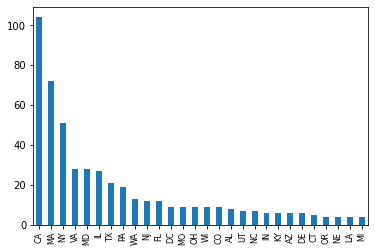

In [238]:
job_locations_reduced.plot(kind='bar')
plt.xticks(fontsize=8)
plt.show()

In [341]:
budget_surplus = merged_df[['State Code','Home Budget Surplus']]
budget_surplus = budget_surplus.sort_values(ascending=True, by='Home Budget Surplus')
budget_surplus.head()

,State Code,Home Budget Surplus
10,ID,4908.0
24,NM,8809.0
5,DC,8858.0
22,NE,9236.0
4,CT,9315.0


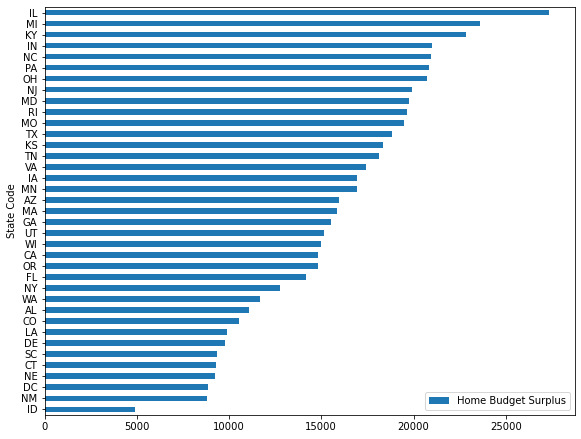

In [360]:
budget_surplus.plot(x='State Code',kind='barh')
plt.yticks(fontsize=10)
plt.rcParams["figure.figsize"] = (9,7)
plt.show()